# VEHICLE DATA EDA + CLEANING

## The aim of this Notebook is clean and do an EDA of the Dataset

## Checklist rapida – EDA + Cleaning

### EDA
- [X] Panoramica dati (`shape`, `dtypes`, `head`)
- [X] Statistiche descrittive (num e cat)
- [X] Analisi missing values
- [X] Distribuzione target (`price`) + valutare log-transform
- [X] Distribuzioni e correlazioni variabili numeriche
- [X] Analisi variabili categoriche (frequenze, boxplot vs `price`)

### Cleaning
- [X] Gestione valori mancanti
- [X] Trattamento outlier
- [X] Definizione `num_cols` e `cat_cols`
- [X] Salvataggio `vehicles_clean.csv`



In [51]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


### Caricamento Dataset

In [52]:
# Load file csv
csv_path = "../Dataset/car data.csv"

df = pd.read_csv(csv_path)

## 1. EDA

### 1. Panoramica dati (`shape`, `dtypes`, `head`)

In [53]:

print("Shape: ",df.shape,"\n")
print("---")
print("Types of Data: \n",df.dtypes)
print("---")
print("Head of dataset: \n",df.head())


Shape:  (301, 9) 

---
Types of Data: 
 Car_Name          object
Year               int64
Selling_Price    float64
Present_Price    float64
Kms_Driven         int64
Fuel_Type         object
Seller_Type       object
Transmission      object
Owner              int64
dtype: object
---
Head of dataset: 
   Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014          3.350          5.590       27000    Petrol   
1      sx4  2013          4.750          9.540       43000    Diesel   
2     ciaz  2017          7.250          9.850        6900    Petrol   
3  wagon r  2011          2.850          4.150        5200    Petrol   
4    swift  2014          4.600          6.870       42450    Diesel   

  Seller_Type Transmission  Owner  
0      Dealer       Manual      0  
1      Dealer       Manual      0  
2      Dealer       Manual      0  
3      Dealer       Manual      0  
4      Dealer       Manual      0  


### 2. Statistiche descrittive (num e cat)

In [54]:
print("Statistiche Descrittive : \n")
print(df.describe().T)
print("---")
cat_cols = ["Car_Name","Fuel_Type","Seller_Type","Transmission"]

for cat in cat_cols:
    print(df[cat].value_counts())
    print("\n")
    print(df[cat].nunique())
    


Statistiche Descrittive : 

                count       mean        std       min        25%        50%  \
Year          301.000  2,013.628      2.892 2,003.000  2,012.000  2,014.000   
Selling_Price 301.000      4.661      5.083     0.100      0.900      3.600   
Present_Price 301.000      7.628      8.644     0.320      1.200      6.400   
Kms_Driven    301.000 36,947.206 38,886.884   500.000 15,000.000 32,000.000   
Owner         301.000      0.043      0.248     0.000      0.000      0.000   

                     75%         max  
Year           2,016.000   2,018.000  
Selling_Price      6.000      35.000  
Present_Price      9.900      92.600  
Kms_Driven    48,767.000 500,000.000  
Owner              0.000       3.000  
---
Car_Name
city                  26
corolla altis         16
verna                 14
fortuner              11
brio                  10
                      ..
Honda Activa 125       1
Hero Hunk              1
Hero  Ignitor Disc     1
Hero  CBZ Xtreme       1


### 3. Analisi missing values

In [55]:
df.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

### 4. Distribuzione target (`price`) + valutare log-transform

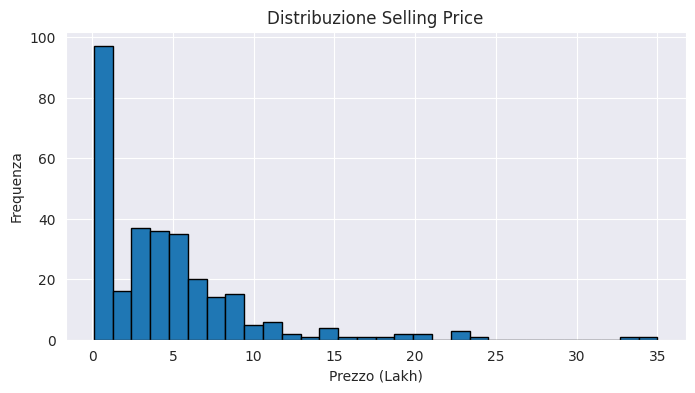

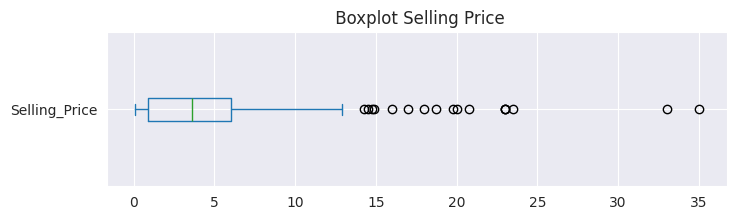

In [56]:
plt.figure(figsize=(8,4))
plt.hist(df["Selling_Price"], bins= 30, edgecolor = "black")
plt.title("Distribuzione Selling Price")
plt.xlabel("Prezzo (Lakh)")
plt.ylabel("Frequenza")
plt.show()

plt.figure(figsize=(8,2))
df["Selling_Price"].plot(kind="box", vert = False)
plt.title(" Boxplot Selling Price")
plt.show()

Cosa vediamo:
- Distribuzione molto sbilanciata a destra (right-skewed) → la maggior parte delle auto costa poco (0–10 lakh), mentre poche hanno prezzi estremamente alti (fino a 35).
- Boxplot: ci sono molti outlier sopra 15–20 lakh.

Questo conferma due cose utili:
- Conviene applicare una log-transform al target (log(selling_price)) per ridurre lo skew e rendere la regressione più stabile.
- Forse dovremo limitare gli outlier (es. tenere solo auto sotto una certa soglia, tipo < 25 lakh).

### 5. Distribuzioni e correlazioni variabili numeriche

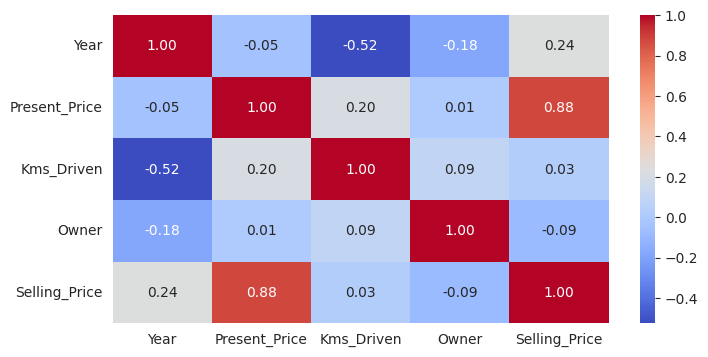

In [57]:
df.columns.tolist()

num_cols = [ "Year", "Present_Price", "Kms_Driven", "Owner", "Selling_Price" ]
# TABLE VERSION
df[num_cols].corr()
# GRAPH VERSION
plt.figure(figsize=(8,4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

Correlazioni principali con selling_price:
- present_price → 0.88
Fortissima correlazione → ha molto senso: il prezzo attuale dipende da quanto l’auto costava nuova.

- year → 0.24
Debole, ma positiva: più recente = prezzo più alto.

- kms_driven → 0.03
Quasi nulla! Probabilmente il prezzo non cala linearmente coi km → magari servirà una trasformazione (log/km).

- owner → -0.09
Correlazione praticamente nulla → probabilmente variabile poco utile.

Conseguenze:
- Il driver principale del prezzo è present_price.
- year aggiunge un po’ di informazione.
- kms_driven e owner hanno poco impatto lineare → valutiamo se tenerli o trasformarli.

### 6. Analisi variabili categoriche (frequenze, boxplot vs `price`)

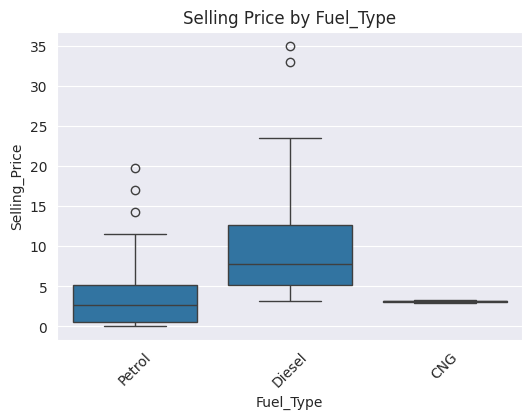

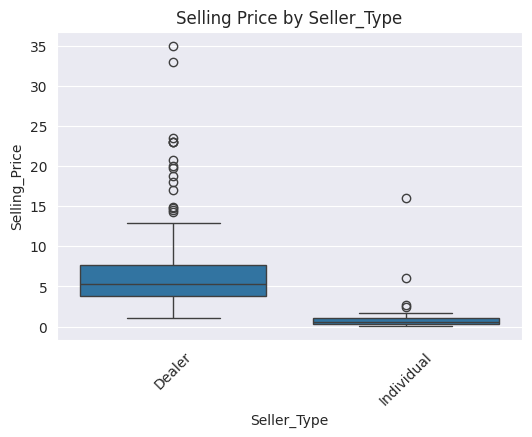

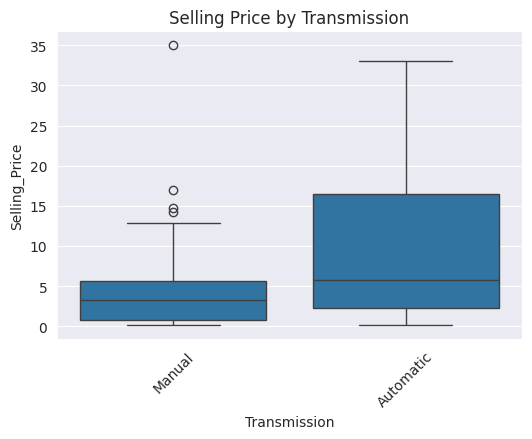

In [58]:
for col in ["Fuel_Type", "Seller_Type", "Transmission"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(x = col, y= "Selling_Price", data = df)
    plt.title(f"Selling Price by {col}")
    plt.xticks(rotation = 45)
    plt.show()

Cosa ci dicono

1. Fuel_Type
    - Diesel ha una mediana di prezzo più alta rispetto a Petrol.

    - CNG è marginale (pochi casi, prezzi molto bassi) → da trattare come categoria rara.

2. Seller_Type

    - Dealer ha prezzi medi decisamente più alti rispetto a Individual.

    - Quindi il tipo di venditore influisce molto sul prezzo → variabile predittiva utile.

3. Transmission

    - Automatic mostra prezzi più alti e una variabilità maggiore rispetto a Manual.

    - Conferma che il tipo di cambio incide sul valore di rivendita.

| Variabile        | Situazione osservata                                                                                            | Decisione pratica                                                                  | Interpretazione nel modello                                                                                           |
| ---------------- | --------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------- |
| **fuel\_type**   | Petrol molto frequente, Diesel meno frequente ma con prezzi più alti, CNG rarissimo (solo 2 casi, prezzi bassi) | **Tenere Petrol e Diesel**, eliminare/accorpare CNG in “Other”                     | Il modello confronterà Diesel vs baseline (Petrol). Effetto ≈ differenza media di prezzo a parità di altre variabili. |
| **seller\_type** | Dealer ha prezzi più alti, Individual più bassi                                                                 | **Tenere entrambe**                                                                | Baseline = Dealer (categoria più frequente). Effetto di Individual = quanto cala il prezzo rispetto a Dealer.         |
| **transmission** | Manual molto più frequente, Automatic meno comune ma con prezzi più alti                                        | **Tenere entrambe**                                                                | Baseline = Manual. Automatic ≈ differenza media di prezzo rispetto a Manual.                                          |
| **car\_name**    | Moltissimi valori unici (troppo dispersivi), non gestibile direttamente                                         | **Da semplificare** → estrarre marca (prima parola del nome) e scartare il modello | Marca = nuova categorica. Effetto stimato rispetto alla marca baseline.                                               |


| Variabile          | Situazione osservata (EDA)                                                                           | Decisione pratica                                                                                   | Interpretazione nel modello                                                              |
| ------------------ | ---------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- |
| **year**           | Correlazione positiva ma debole con il prezzo (≈0.24). Auto più nuove → prezzo leggermente più alto. | **Tenere**. Eventualmente trasformare in “age” = anno corrente − year (più interpretabile).         | Coefficiente ≈ quanto aumenta/diminuisce il prezzo per 1 anno in più (o in meno di età). |
| **present\_price** | Correlazione molto forte con il prezzo (≈0.88). Driver principale del target.                        | **Tenere** assolutamente.                                                                           | Coefficiente ≈ effetto lineare del prezzo di listino sul prezzo di rivendita.            |
| **kms\_driven**    | Correlazione quasi nulla (≈0.03). Distribuzione asimmetrica con valori molto grandi.                 | **Trasformare** → usare log(kms) o normalizzazione. Potrebbe diventare più informativa.             | Coefficiente ≈ variazione del prezzo al crescere dei km (dopo log: interpretazione %).   |
| **owner**          | Correlazione trascurabile (≈−0.09). Valori quasi tutti = 0 o 1, pochi casi con 2+.                   | **Opzionale**: si può tenere come categorica (0,1,2+) oppure scartare se non aggiunge predittività. | Effetto medio sul prezzo in base al numero di precedenti proprietari.                    |


## 2. Cleaning

### 1. Gestione Missing Values

Non ci sono missing values

### 2. Trattamento Outlier

In [59]:
n_before = len(df)
p99 = df["Selling_Price"].quantile(0.99)
df = df[df["Selling_Price"] <= p99 ]
n_after = len(df)
n_removed = n_before - n_after
print(f"Righe iniziali Selling_Price : {n_before}")
print(f"Righe finali Selling_Price: {n_after}")
print(f"Righe rimosse Selling_Price : {n_removed}")

Righe iniziali Selling_Price : 301
Righe finali Selling_Price: 298
Righe rimosse Selling_Price : 3


In [60]:
n_before = len(df)

p01 = df["Kms_Driven"].quantile(0.01)
p99 = df["Kms_Driven"].quantile(0.99)

df = df[df["Kms_Driven"] <= p99]
df = df[df["Kms_Driven"] >= p01]

n_after = len(df)
n_removed = n_before - n_after
print(f"Righe iniziali Kms_Driven : {n_before}")
print(f"Righe finali Kms_Driven: {n_after}")
print(f"Righe rimosse Kms_Driven : {n_removed}")

df["Kms_Driven_Log"] = np.log1p(df["Kms_Driven"])


Righe iniziali Kms_Driven : 298
Righe finali Kms_Driven: 292
Righe rimosse Kms_Driven : 6


In [61]:
curr_year = datetime.now().year
print("Anno di riferimento per calcolare age:", curr_year)
df["Age"] = curr_year - df["Year"]
neg_age = (df["Age"] < 0).sum()
if neg_age > 0:
    print(f"Attenzione: {neg_age} righe con Age < 0. Verranno rimosse.")
    df = df[df["Age"] >= 0]

p99_age = df["Age"].quantile(0.99)
df = df[df["Age"] <= p99_age]

df = df.drop(columns = ["Year"])

Anno di riferimento per calcolare age: 2025


### 3. Definizione `num_cols` e `cat_cols`

In [62]:
# dopo l’EDA e PRIMA di definire num_cols/cat_cols
df["Brand"] = df["Car_Name"].str.split().str[0].str.title()

df["Owner_Group"] = (
    df["Owner"]
      .where(df["Owner"] < 2, 2)                 # 0,1,2
      .map({0: "owner_0", 1: "owner_1", 2: "owner_2plus"})
)

num_cols = ["Present_Price","Age","Kms_Driven_Log"]
cat_cols = ["Fuel_Type", "Seller_Type", "Transmission", "Brand", "Owner_Group"]

print("Numeriche:", num_cols)
print("Categoriche:", cat_cols)

Numeriche: ['Present_Price', 'Age', 'Kms_Driven_Log']
Categoriche: ['Fuel_Type', 'Seller_Type', 'Transmission', 'Brand', 'Owner_Group']


### 4. Salvataggio `vehicles_clean.csv`

In [65]:
final_cols = ["Selling_Price"] + num_cols + cat_cols

missing = [c for c in (["Selling_Price"] + num_cols + cat_cols) if c not in df.columns]
print("Colonne mancanti:", missing)

df_clean = df[final_cols].copy()

print("Shape finale:", df_clean.shape)
print("Missing values:\n", df_clean.isna().sum())

out_path = "../output/results/vehicles_clean.csv"
df_clean.to_csv(out_path, index=False)
print(f"Dataset pulito salvato in: {out_path}")


check = pd.read_csv(out_path)
print("Shape ricaricato:", check.shape)
check.head()

Colonne mancanti: []
Shape finale: (289, 9)
Missing values:
 Selling_Price     0
Present_Price     0
Age               0
Kms_Driven_Log    0
Fuel_Type         0
Seller_Type       0
Transmission      0
Brand             0
Owner_Group       0
dtype: int64
Dataset pulito salvato in: ../output/results/vehicles_clean.csv
Shape ricaricato: (289, 9)


,Selling_Price,Present_Price,Age,Kms_Driven_Log,Fuel_Type,Seller_Type,Transmission,Brand,Owner_Group
0,3.350,5.590,11,10.204,Petrol,Dealer,Manual,Ritz,owner_0
1,4.750,9.540,12,10.669,Diesel,Dealer,Manual,Sx4,owner_0
2,7.250,9.850,8,8.839,Petrol,Dealer,Manual,Ciaz,owner_0
3,2.850,4.150,14,8.557,Petrol,Dealer,Manual,Wagon,owner_0
4,4.600,6.870,11,10.656,Diesel,Dealer,Manual,Swift,owner_0
